In [3]:
import pandas as pd
import re
import nltk
import spacy
import requests
import time
import json
import requests
from nltk.tokenize import sent_tokenize
import unicodedata
import base64
import io
import requests
from rapidfuzz import fuzz
import re
import textwrap
from ollama import Client
OLLAMA_URL = "http://localhost:11434"  # ✅ Just the base URL
import time
client = Client(host=OLLAMA_URL)
from collections.abc import Iterable
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import umap
from sklearn.manifold import TSNE

/Users/harshitachakravadhanula./anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# 1. remove translations.
# 2. fix aliases and extraction and classification prompts

In [346]:
df = pd.read_csv('/Users/harshitachakravadhanula./Desktop/sem2/thesis/Dataset/wip dfs/characters_450.csv')

In [384]:
df


,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,bookshelves,copyright_status,media_type,formats,download_link,textContent,translator,translation_date,original_date,date_range_confidence
0,0,Circe,A powerful sorceress who lives on the island o...,female,1,odyssey,1727,The Odyssey: Rendered into English prose for t...,Homer,en,...,Browsing: History - Ancient; Browsing: Literat...,False,Text,"text/html, application/epub+zip, application/x...",https://www.gutenberg.org/ebooks/1727.txt.utf-8,﻿The Project Gutenberg eBook of The Odyssey\r\...,Samuel Butler,1999.0,-800,100
1,1,Circe,A powerful sorceress who lives on the island o...,female,1,odyssey,3160,The Odyssey,Homer,en,...,Banned Books from Anne Haight's list; Browsing...,False,Text,"text/html, text/html; charset=utf-8, applicati...",https://www.gutenberg.org/files/3160/3160-0.txt,"﻿The Project Gutenberg eBook of The Odyssey, b...",Alexander Pope,2002.0,-800,100
2,2,Circe,A powerful sorceress who lives on the island o...,female,1,odyssey,48895,"The Odysseys of Homer, together with the short...",Homer,en,...,Browsing: Literature; Browsing: Poetry,False,Text,"text/plain; charset=us-ascii, text/html, text/...",https://www.gutenberg.org/ebooks/48895.txt.utf-8,﻿The Project Gutenberg eBook of The Odysseys o...,George Chapman,2015.0,-800,100
3,3,Creusa,The first wife of Aeneas and mother of Ascaniu...,female,1,aeneid,228,The Aeneid,Virgil,en,...,Best Books Ever Listings; Browsing: History - ...,False,Text,"text/html, application/epub+zip, application/x...",https://www.gutenberg.org/ebooks/228.txt.utf-8,﻿The Project Gutenberg eBook of The Aeneid\r\n...,John Dryden,1995.0,-19,10
4,4,Creusa,The first wife of Aeneas and mother of Ascaniu...,female,1,aeneid,22456,The Aeneid of Virgil,Virgil,en,...,Browsing: History - General; Browsing: Literat...,False,Text,"text/html, application/epub+zip, application/x...",https://www.gutenberg.org/ebooks/22456.txt.utf-8,﻿The Project Gutenberg eBook of The Aeneid of ...,J. W. Mackail,2007.0,-19,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,444,Queen Modthryth,A wicked queen of legend who punishes those wh...,female,1,beowulf,9700,I. Beówulf: an Anglo-Saxon poem. II. The fight...,Unknown,ang,...,Browsing: Literature; Browsing: Poetry; Poetry,False,Text,"text/html, text/html; charset=utf-8, applicati...",https://www.gutenberg.org/files/9700/9700-0.txt,﻿The Project Gutenberg eBook of Beowulf\r\n\r\...,Unknown,2003.0,975,75
445,445,The Virgin Mary,"The Virgin Mary appears to Alfred in visions, ...",female,1,white horse,1719,The Ballad of the White Horse,"Chesterton, G. K. (Gilbert Keith)",en,...,Browsing: History - British; Browsing: Literat...,False,Text,"text/html, application/epub+zip, application/x...",https://www.gutenberg.org/ebooks/1719.txt.utf-8,﻿The Project Gutenberg eBook of The Ballad of ...,Unknown,1999.0,1911,0
446,446,Old Woman,An unnamed old woman gives Alfred a cake and t...,female,1,white horse,1719,The Ballad of the White Horse,"Chesterton, G. K. (Gilbert Keith)",en,...,Browsing: History - British; Browsing: Literat...,False,Text,"text/html, application/epub+zip, application/x...",https://www.gutenberg.org/ebooks/1719.txt.utf-8,﻿The Project Gutenberg eBook of The Ballad of ...,Unknown,1999.0,1911,0
447,447,Venus,Roman goddess of love who supports the Portugu...,female,1,lusiad,32528,"The Lusiad; Or, The Discovery of India, an Epi...","Camões, Luís de",en,...,Browsing: History - General; Browsing: Literat...,False,Text,"text/html, text/html; charset=iso-8859-1, appl...",https://www.gutenberg.org/ebooks/32528.txt.utf-8,﻿The Project Gutenberg eBook of The Lusiad; Or...,Pope:--,2010.0,1572,0


In [347]:
df['normalized_title'].unique()


array(['odyssey', 'aeneid', 'iliad', 'paul', 'volsunga saga',
       'works and days', 'divine comedy', 'kalevala', 'hiawatha',
       'montezuma', 'edda', 'gilgamesh', 'tale of genji', 'ramayana',
       'hades', 'theogony', 'roland', 'shield of heracles', 'gudrun',
       'gods of the north', 'shahnameh', 'mahabharata', 'pan tadeusz',
       'nibelungenlied', 'journey to the west', 'beowulf', 'white horse',
       'lusiad'], dtype=object)

In [385]:
df_genji =df[df['normalized_title'].str.lower().str.contains('tale of genji')].copy()


In [386]:
df_genji

,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,bookshelves,copyright_status,media_type,formats,download_link,textContent,translator,translation_date,original_date,date_range_confidence
179,179,Lady Kiritsubo,(the Kiritsubo Intimate/ Kiritsubo Kōi/ Kirits...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
180,180,Lady Kokiden,( Kokiden Consort ) – Kiritsubo Emperor's cons...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
181,181,Lady Fujitsubo,(Her Highness/ Majesty Fujitsubo) – Daughter o...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
182,182,Ōmyōbu,(Fujitsubo's Ōmyōbu) – She is a lady-in-waitin...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
183,183,Tō no Chūjō,– The son of the Minister of the Left and brot...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
184,184,Lady Aoi,( Aoi no Ue ) – Daughter of the Minister of th...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
185,185,Utsusemi,(空蝉/Cicada Shell/ Lady of the Locust Shell) – ...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
186,186,Chūjō,(Utsusemi's Chūjō) – She is Utsusemi's servant...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
187,187,Nokiba no Ogi,– She is the daughter of the Iyo Deputy and th...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
188,188,Yūgao,– She is a woman of lower status of about nine...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,

In [354]:
#taking care of all the translations
# df_genji = df_genji[df_genji['id'] == 11000]


In [355]:
#lets try ollama

In [387]:


def split_by_book(text, title=None, min_sections=5, fallback_char_limit=10000):
    patterns = {
        "BOOK_ROMAN": r'\bBOOK\s+[IVXLCDM]+\b',
        "BOOK_WORD": r'\bBOOK\s+(ONE|TWO|THREE|FOUR|FIVE|SIX|SEVEN|EIGHT|NINE|TEN|ELEVEN|TWELVE)\b',
        "CANTO": r'\bCANTO\s+[IVXLCDM]+\b',
        "ADVENTURE": r'\bADVENTURE\s+[IVXLCDM]+\b',
        "PART": r'\bPART\s+[IVXLCDM]+\b',
        "SECTION": r'\bSECTION\s+[IVXLCDM]+\b',
        "TABLET": r'\bTABLET\s+[IVXLCDM]+\b',
        "CHAPTER": r'\bCHAPTER\s+[IVXLCDM]+\b',
        "LAISSE": r'\bLAISSE\s+\d+\b',
        "EPISODE": r'\bEPISODE\s+\d+\b',
    }

    best_split = [text]
    best_label = "none"

    for label, pattern in patterns.items():
        marked = re.sub(pattern, r'\n\n===\g<0>===\n\n', text, flags=re.IGNORECASE)
        parts = marked.split('\n\n===')[1:]
        if len(parts) >= min_sections:
            best_split = parts
            best_label = label
            break

    # 🧱 Fallback — if no sections but text is long, chunk it by size
    if best_label == "none" and len(text) > fallback_char_limit:
        avg_len = fallback_char_limit
        best_split = textwrap.wrap(text, width=avg_len)
        best_label = f"fallback_chunks (~{len(best_split)} parts)"

    if title:
        print(f"🧠 Pattern selected for '{title}': {best_label} ({len(best_split)} sections)")

    return best_split


In [388]:
def get_character_aliases(character, epic, bio, translator=None, model="llama3", temperature=0.0, top_p=0.9):
    system = f"""
    You are a helpful assistant and a scholar of the text *{epic}*, specifically the Japanese epic {epic}. 
    Your task is to return a clean, comma-separated list of all possible aliases, alternate spellings, 
    and unique descriptive phrases that refer to the character {character} in *{epic}*. 
    Be careful not to include aliases of other characters. For context, this character is: {bio}

    This version fits the traditional accounts of The Tale of Genji’s characters and narrative structure, which often involve:
    Multiple names or epithets for a character depending on the passage
    (e.g., Genji may be called “the Shining Prince,” “Hikaru no Kimi,” “the Minister of the Left’s son,” or “His Excellency of Rokujō”).
    Relational identifiers, such as references to court rank, family lineage, or romantic ties
    (e.g., “son of Kiritsubo,” “fostered by the Emperor,” “beloved of Lady Murasaki,” or “father of Reizei”).
    Poetic and cultural titles, often used in seasonal imagery or layered metaphor
    (e.g., “blossom beneath the moon,” “the fragrance of courtly elegance,” “clouded mirror of longing,” or “the prince of fleeting beauty”).

    You are focusing on the version translated by {translator}.
    Return a **clean, comma-separated list** of short phrases, titles, or names — no explanations or quotes. 
    Do **not** include overly general descriptors (like "beautiful woman" or "noble lady"), only epithets clearly tied to this character.
    This list will be used for pattern matching and quote extraction, so keep it concise and precise. 
    Do not include quotation marks, numbers, or any explanations. ***DO NOT INCLUDE ANYTHING OTHER THAN THE ALIASES.****
    """

    prompt = f"""
    In the context of *{epic}*, what are all the known aliases, alternate spellings, or uniquely identifying phrases
    used to refer to the character "{character}"? This should include alternate names,
    relational titles like "daughter of X", and mythic identifiers unique to this character in {translator}'s translation.
    Return only the clean, comma-separated list.
    """

    print("📝 Prompt being sent to LLM:")
    print(prompt)

    response = query_ollama(
        prompt=prompt,
        model=model,
        temperature=temperature,
        top_p=top_p,
        system=system
    )

    print("🧠 Raw response from LLM:")
    print(response)

    if not response:
        return []

    return [alias.strip().lower() for alias in response.split(",") if alias.strip()]


In [389]:
def normalize_text(s):
    # Strip accents and normalize to lowercase
    nfkd_form = unicodedata.normalize('NFKD', s)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)]).lower()

In [390]:
def filter_character_chunks_with_context(text, character, translator, epic, bio, window_size=300):
    chunks = []

    # Only take actual books (last 24 blocks)
    all_books = split_by_book(text)
    real_books = all_books

    # Get aliases using LLM and normalize them
    aliases = get_character_aliases(character, epic, bio, translator )
    normalized_aliases = [normalize_text(alias) for alias in aliases]
    
    
    # ✅ Ensure the base character name is included
    normalized_character = normalize_text(character)
    if normalized_character not in normalized_aliases:
        normalized_aliases.append(normalized_character)

    print("Aliases:", normalized_aliases)

    
    # Normalize all book texts for matching
    character_books = [
        book for book in real_books
        if any(alias in normalize_text(book) for alias in normalized_aliases)
    ]
    print("Number of books they are in:", len(character_books))

    for book in character_books:
        words = book.split()
        for i, word in enumerate(words):
            norm_word = normalize_text(word)
            if any(alias in norm_word for alias in normalized_aliases):
                start = max(0, i - window_size)
                end = min(len(words), i + window_size)
                chunk = ' '.join(words[start:end])
                chunks.append(chunk)

    # Remove duplicates
    seen = set()
    unique_chunks = []
    for c in chunks:
        if c not in seen:
            seen.add(c)
            unique_chunks.append(c)

    return unique_chunks


In [391]:
# 2. Chunk Text (300-600 words)
def chunk_text(text, chunk_size=400):
    words = text.split()
    return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]


In [392]:
# 3. Prompt Constructor
def make_prompt(chunk, character):
    return (
    "Extract quotes by "+character+" in the following passage, send it back as a json."
    "Text:\n\n" + chunk
)

    

In [393]:
def query_ollama(prompt, model, temperature=0.0, top_p=1.0, system=None):
    messages = []

    if system:
        messages.append({'role': 'system', 'content': system})
    
    messages.append({'role': 'user', 'content': prompt})

    try:
        response = client.chat(
            model=model,
            messages=messages,
            options={
                'temperature': temperature,
                'top_p': top_p
            }
        )
        return response["message"]["content"]
    except Exception as e:
        return f"Error: {e}"


In [394]:
# 5. Parse JSON Safely
def extract_json_list(text):
    try:
        cleaned = text.strip()
        if cleaned.startswith('"') and cleaned.endswith('"'):
            cleaned = cleaned[1:-1]
        match = re.search(r'\[.*\]', cleaned, re.DOTALL)
        if match:
            return json.loads(match.group(0))
    except Exception as e:
        return f"❌ Parse Error: {e}"
    return "❌ No JSON found"

In [395]:
def run_extraction(full_text, character, translator, epic, bio):
    print("📤 Filtering "+character+"-related text...")
    filtered = filter_character_chunks_with_context(full_text, character, translator, epic, bio)

    print("🧱 Chunking...")
    filtered_text = ' '.join(filtered)  # FIX: join the list into a single string
    chunks = chunk_text(filtered_text, chunk_size=400)

    all_quotes = []
    for i, chunk in enumerate(chunks):
        print(f"⏳ Querying chunk {i+1}/{len(chunks)}...")
        prompt = make_prompt(chunk, character)
        system = (
    f"""You are a helpful assistant that extracts any and all text related to the character {character} from the {epic}."
        In the context of The Tale of Genji—particularly in classical Japanese prose or poetic translation—character speech may not always be directly attributed with phrases like “he said” or “she replied.”
        Please identify direct speech, embedded dialogue, and poetic or ceremonial exchanges, especially within courtship letters, monologues of longing, religious reflections, or conversations veiled in metaphor.
        Be aware that entire sections may consist of alternating speakers or speech interwoven with narrative description, without clear attribution in every line. Also account for poetic repetition, honorific titles (e.g., “Her Highness of the Paulownia Court,” “Genji no Kimi,” “the Lady of Akashi”), set phrases, and seasonal or nature-linked metaphors, which are stylistic features of Heian literary tradition.
        If context clearly links a line or passage to a character (even without quotation marks or direct cues), include it as part of their speech.Return only the relevant lines as a JSON list of strings. Do not return summaries, analysis, or commentary.
        If no such lines are found in the passage, return an empty JSON list: []"""    )
        time.sleep(0.5)  # or even 0.2
        quotes = query_ollama(chunk, 'llama3', 0.0, 0.8, system)
        
        print(quotes)
        all_quotes.append(quotes)


    return all_quotes


In [396]:
def clean_text(raw_responses):
    """
    Takes a list of raw LLM responses (JSON array of quotes).
    Returns a clean list of individual quotes (strings only).
    """
    clean_quotes = []

    for response in raw_responses:
        match = re.search(r'\[.*?\]', response, re.DOTALL)
        if match:
            try:
                quotes = json.loads(match.group(0))
                if isinstance(quotes, list):
                    for q in quotes:
                        if isinstance(q, str):
                            cleaned = q.strip()
                            if cleaned:
                                clean_quotes.append(cleaned)
            except json.JSONDecodeError:
                continue

    return clean_quotes


In [397]:
def classify_character_quotes(character, quote, epic,  model="llama3", temperature=0.2, top_p=0.9):
    system = (
        f"You are a helpful literary analyst of the Japanese epic *{epic} *. "
        f"Your job is to classify quotes in relation to the character {character}. "
        f"Only use the quote and surrounding context to decide."
        f"""Classify each quote with one of the following labels:
            - "by {character}" if it is spoken by {character}
            - "about {character}" if it describes or mentions {character}
            - "unrelated" if it has nothing to do with {character}"""
    )

    prompt = f"""
Classify each quote with one of the following labels:
- "by {character}" if it is spoken by {character}
- "about {character}" if it describes or mentions {character}
- "unrelated" if it has nothing to do with {character}

Here are a few examples:

Example 1:
Quote: "Rise, rise, my mates! 'tis Circe gives command."
Label: by circe

Example 2:
Quote: "Circe in vain invites the feast to share;"
Label: about circe

Example 3:
Quote: "The ships reached the shore and the men disembarked."
Label: unrelated

Now classify this:

Quote: "{quote}"


Label:
"""

    # Send to model
    response = query_ollama(prompt=prompt, model=model, temperature=temperature, top_p=top_p, system=system)

    # Normalize and clean the result
    result = response.strip().lower()

    # Map flexible variations to final labels
    if "by" in result:
        return "by"
    elif "about" in result:
        return "about"
    elif "unrelated" in result:
        return "unrelated"
    else:
        return "unrelated"  # fallback


In [398]:
df_genji 


,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,bookshelves,copyright_status,media_type,formats,download_link,textContent,translator,translation_date,original_date,date_range_confidence
179,179,Lady Kiritsubo,(the Kiritsubo Intimate/ Kiritsubo Kōi/ Kirits...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
180,180,Lady Kokiden,( Kokiden Consort ) – Kiritsubo Emperor's cons...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
181,181,Lady Fujitsubo,(Her Highness/ Majesty Fujitsubo) – Daughter o...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
182,182,Ōmyōbu,(Fujitsubo's Ōmyōbu) – She is a lady-in-waitin...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
183,183,Tō no Chūjō,– The son of the Minister of the Left and brot...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
184,184,Lady Aoi,( Aoi no Ue ) – Daughter of the Minister of th...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
185,185,Utsusemi,(空蝉/Cicada Shell/ Lady of the Locust Shell) – ...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
186,186,Chūjō,(Utsusemi's Chūjō) – She is Utsusemi's servant...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
187,187,Nokiba no Ogi,– She is the daughter of the Iyo Deputy and th...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,Arthur Waley,2021.0,1008,10
188,188,Yūgao,– She is a woman of lower status of about nine...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,Browsing: Culture/Civilization/Society; Browsi...,False,Text,"application/octet-stream, text/html, applicati...",https://www.gutenberg.org/ebooks/66057.txt.utf-8,﻿The Project Gutenberg eBook of The Tale of Ge...,

In [399]:

# Initialize new columns (only once)
if "quotes_by" not in df_genji.columns:
    df_genji["quotes_by"] = None
    df_genji["quotes_about"] = None
    df_genji["unrelated_quotes"] = None
    df_genji["raw_quotes"] = None

start_time = time.time()

for idx, row in df_genji.iterrows():
    character = row["character_name"]
    text = row["textContent"]
    translator = row["translator"]
    epic = row["normalized_title"]
    bio = row["bio"]
    print(f"\n📤 Processing character: {character}")

    try:
        # Step 1: Run the extraction
        quotes = run_extraction(text, character, translator, epic, bio)

        # Step 2: Clean extracted quotes
        clean_quotes = clean_text(quotes)
        print(f"✅ Cleaned {len(clean_quotes)} quotes for {character}")

        # 💾 Save raw quotes (safe even before classification)
        df_genji.at[idx, "raw_quotes"] = clean_quotes

        # 🔁 Save progress after each character
        df_genji.to_json("df_genji_raw_quotes.json", orient="records", indent=2, force_ascii=False)

        # Step 3: Classify quotes
        quotes_by = []
        quotes_about = []
        unrelated = []

        for quote in clean_quotes:
            try:
                label = classify_character_quotes(character, quote, epic, model="llama3", temperature=0.1, top_p=0.7)
                label = label.strip().lower()
            except Exception as e:
                print(f"⚠️ Classification failed for quote: {quote[:50]}... — {e}")
                label = "unrelated"

            if "by" in label:
                quotes_by.append(quote)
            elif "about" in label:
                quotes_about.append(quote)
            else:
                unrelated.append(quote)

        # Step 4: Store categorized quotes
        df_genji.at[idx, "quotes_by"] = quotes_by
        df_genji.at[idx, "quotes_about"] = quotes_about
        df_genji.at[idx, "unrelated_quotes"] = unrelated

        print(f"📦 Stored for {character} — {len(quotes_by)} by / {len(quotes_about)} about / {len(unrelated)} unrelated")

        time.sleep(1)

    except KeyboardInterrupt:
        print("🛑 Interrupted by user. Saving progress...")
        break
    except Exception as e:
        print(f"❌ Error processing {character}: {e}")
        continue  # Skip and continue with next character

# Final save
df_genji.to_json("df_genji_with_quotes.json", orient="records", indent=2, force_ascii=False)

end_time = time.time()
total_minutes = (end_time - start_time) / 60
print(f"\n✅ All done! Total time taken: {total_minutes:.2f} minutes")



📤 Processing character: Lady Kiritsubo
📤 Filtering Lady Kiritsubo-related text...
📝 Prompt being sent to LLM:

    In the context of *tale of genji*, what are all the known aliases, alternate spellings, or uniquely identifying phrases
    used to refer to the character "Lady Kiritsubo"? This should include alternate names,
    relational titles like "daughter of X", and mythic identifiers unique to this character in Arthur Waley's translation.
    Return only the clean, comma-separated list.
    
🧠 Raw response from LLM:
Kiritsubo Consort, Kiritsubo Kōi, Kiritsubo Intimate, daughter of Grand Counselor, Paulownia Pavilion lady
Aliases: ['kiritsubo consort', 'kiritsubo koi', 'kiritsubo intimate', 'daughter of grand counselor', 'paulownia pavilion lady', 'lady kiritsubo']
Number of books they are in: 0
🧱 Chunking...
✅ Cleaned 0 quotes for Lady Kiritsubo
📦 Stored for Lady Kiritsubo — 0 by / 0 about / 0 unrelated

📤 Processing character: Lady Kokiden
📤 Filtering Lady Kokiden-related text..

In [400]:
df_genji.to_csv("/Users/harshitachakravadhanula./Desktop/sem2/thesis/Dataset/archetype finals/df_genji_.csv")

In [11]:

def flatten_quotes(q):
    # Safely flatten any nested list, skipping non-strings
    if isinstance(q, str):
        return [q]
    elif isinstance(q, Iterable):
        flat = []
        for item in q:
            if isinstance(item, str):
                flat.append(item)
            elif isinstance(item, Iterable):
                flat.extend([i for i in item if isinstance(i, str)])
        return flat
    else:
        return []


In [402]:

df_genji['quotes_by'].apply(flatten_quotes)
df_genji['quotes_about'].apply(flatten_quotes)

179                                                   []
180                                                   []
181    [Fujitsubo's position and hope that later on s...
182    [The girl, though she regarded any communicati...
183                                                   []
184                                                   []
185    [hailstones that melt if gathered in the hand....
186    [Are you not of this mind?' Tō no Chūjō nodded...
187                                                   []
188    [those were the words that came into her mind,...
189    [One day, seeing a carriage with outriders com...
190    [small wonder if she was distressed and astoun...
191    [small wonder if she was distressed and astoun...
192    [I know that to-night my lover will come to me...
193                                                   []
194                                                   []
195                                                   []
196                            

In [403]:

file_path = "/Users/harshitachakravadhanula./Desktop/sem2/thesis/Dataset/archetype finals/archetypes_latest.csv"
archetype_df = pd.read_csv(file_path)


archetype_df


,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,Embedding,Cluster,Embedding_reduced,cluster_distance,cluster_strength,size,region,lat,lon,saidvsabout
0,277,Gordafarid,Gordafarid is the daughter of Gazhdaham who is...,female,1,shahnameh,1,Shahnameh,Abolqasem Ferdowsi,en,...,[ 3.25414166e-02 4.27423678e-02 -7.74247106e-...,4,[13.875059 91.734375 73.902336],40.149960,0.024301,6.417235,Iran,32.4279,53.6880,0.461538
1,279,Rudabeh,"Rudabeh is the daughter of Mihrab, the ruler o...",female,1,shahnameh,1,Shahnameh,Abolqasem Ferdowsi,en,...,[ 2.34055147e-02 2.31765639e-02 -1.76993664e-...,4,[49.4044 68.47732 61.252907],40.190510,0.024277,6.412840,Iran,32.4279,53.6880,0.505263
2,281,Sudabeh,Sudabeh is the daughter of the king of Hamavar...,female,1,shahnameh,1,Shahnameh,Abolqasem Ferdowsi,en,...,[ 2.03630831e-02 1.08171199e-02 -1.10149793e-...,4,[10.618522 58.218063 41.179447],22.069733,0.043347,9.916466,Iran,32.4279,53.6880,0.810000
3,282,Tahmineh,Tahmineh is the daughter of the king of Samang...,female,1,shahnameh,1,Shahnameh,Abolqasem Ferdowsi,en,...,[ 3.91322784e-02 1.45071149e-02 -1.74565520e-...,4,[22.999744 59.844574 93.14069 ],33.030580,0.029385,7.351315,Iran,32.4279,53.6880,0.388889
4,100,Minnehaha,Hiawatha’s beloved and wife. Known as Laughing...,female,1,hiawatha,30795,The Song of Hiawatha: An Epic Poem,"Longfellow, Henry Wadsworth",en,...,[ 4.19755988e-02 9.84756462e-03 -3.90871502e-...,6,[-16.067633 -92.52693 -45.71039 ],56.542587,0.017378,5.145284,Northeastern North America,43.0000,-75.0000,0.894869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,364,tapati,Tapati is a river goddess. She is daughter ofS...,female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,1,[ -4.631913 31.974823 -40.739304],5.550645,0.152657,30.000000,India,25.3176,82.9739,1.000000
131,366,tilottama,"In the Hindu epicMahabharata, Tilottama is des...",female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,1,[ -4.631913 31.974823 -40.739304],5.550645,0.152657,30.000000,India,25.3176,82.9739,1.000000
132,152,the sirens,These are the dangerous ladies who lure men to...,female,1,odyssey,1727,The Odyssey: Rendered into English prose for t...,Homer,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,1,[ -4.631913 31.974823 -40.739304],5.550645,0.152657,30.000000,Greece,37.9838,23.7275,1.000000
133,349,sarama,"Sarama, according to theMahabharata, is a cele...",female,1,mahabharata,15474,"The Mahabharata of Krishna-Dwaipayana Vyasa, V...",Unknown,en,...,[ 4.73306142e-02 -9.28251538e-05 -2.22707652e-...,0,[ 44.132538 -91.571106 79.812904],63.807130,0.015430,4.787371,India,25.3176,82.9739,0.514970


In [404]:
archetype_df = pd.concat([df_genji, archetype_df], ignore_index=True)

In [405]:
archetype_df

,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,Embedding,Cluster,Embedding_reduced,cluster_distance,cluster_strength,size,region,lat,lon,saidvsabout
0,179,Lady Kiritsubo,(the Kiritsubo Intimate/ Kiritsubo Kōi/ Kirits...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,180,Lady Kokiden,( Kokiden Consort ) – Kiritsubo Emperor's cons...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,181,Lady Fujitsubo,(Her Highness/ Majesty Fujitsubo) – Daughter o...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,182,Ōmyōbu,(Fujitsubo's Ōmyōbu) – She is a lady-in-waitin...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183,Tō no Chūjō,– The son of the Minister of the Left and brot...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,364,tapati,Tapati is a river goddess. She is daughter ofS...,female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,1.0,[ -4.631913 31.974823 -40.739304],5.550645,0.152657,30.000000,India,25.3176,82.9739,1.000000
155,366,tilottama,"In the Hindu epicMahabharata, Tilottama is des...",female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,1.0,[ -4.631913 31.974823 -40.739304],5.550645,0.152657,30.000000,India,25.3176,82.9739,1.000000
156,152,the sirens,These are the dangerous ladies who lure men to...,female,1,odyssey,1727,The Odyssey: Rendered into English prose for t...,Homer,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,1.0,[ -4.631913 31.974823 -40.739304],5.550645,0.152657,30.000000,Greece,37.9838,23.7275,1.000000
157,349,sarama,"Sarama, according to theMahabharata, is a cele...",female,1,mahabharata,15474,"The Mahabharata of Krishna-Dwaipayana Vyasa, V...",Unknown,en,...,[ 4.73306142e-02 -9.28251538e-05 -2.22707652e-...,0.0,[ 44.132538 -91.571106 79.812904],63.807130,0.015430,4.787371,India,25.3176,82.9739,0.514970


In [406]:
archetype_df.to_csv("/Users/harshitachakravadhanula./Desktop/sem2/thesis/Dataset/archetype finals/archetypes_latest.csv", index=False)
#saving with the quotes because im paranoid.

In [407]:
#^ is new one. 

In [6]:
for_locs=pd.read_csv("/Users/harshitachakravadhanula./Desktop/sem2/thesis/Dataset/archetype finals/archetypes_latest.csv")
for_locs              

,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,Embedding,Cluster,Embedding_reduced,cluster_distance,cluster_strength,size,region,lat,lon,saidvsabout
0,181,Lady Fujitsubo,(Her Highness/ Majesty Fujitsubo) – Daughter o...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,[ 6.21467121e-02 1.30989403e-03 -7.34860078e-...,4,[ 32.779705 -99.29396 -1.6732581],59.657597,0.016486,4.814840,Japan,36.2048,138.2529,0.571429
1,182,Ōmyōbu,(Fujitsubo's Ōmyōbu) – She is a lady-in-waitin...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,[ 4.05362882e-02 2.55386904e-02 -1.99665539e-...,4,[ 9.744972 -77.468895 65.88843 ],26.319525,0.036604,7.763480,Japan,36.2048,138.2529,0.416667
2,185,Utsusemi,(空蝉/Cicada Shell/ Lady of the Locust Shell) – ...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,[ 2.99557578e-02 1.98371895e-02 -1.53581640e-...,4,[ 55.6866 -49.82203 38.80495],42.901300,0.022778,5.737104,Japan,36.2048,138.2529,0.354610
3,186,Chūjō,(Utsusemi's Chūjō) – She is Utsusemi's servant...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,[ 3.33975367e-02 1.30157033e-02 -1.20454310e-...,4,[ 26.564487 -70.529144 29.926565],18.549719,0.051152,9.895721,Japan,36.2048,138.2529,0.474860
4,188,Yūgao,– She is a woman of lower status of about nine...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,[ 4.55286689e-02 2.12960485e-02 -1.29210148e-...,4,[ 18.075043 -105.356476 39.714176],41.051605,0.023780,5.883956,Japan,36.2048,138.2529,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,364,tapati,Tapati is a river goddess. She is daughter ofS...,female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,0,[ 44.2007 4.440636 -26.252361],4.310157,0.188318,30.000000,India,25.3176,82.9739,1.000000
141,366,tilottama,"In the Hindu epicMahabharata, Tilottama is des...",female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,0,[ 44.2007 4.440636 -26.252361],4.310157,0.188318,30.000000,India,25.3176,82.9739,1.000000
142,152,the sirens,These are the dangerous ladies who lure men to...,female,1,odyssey,1727,The Odyssey: Rendered into English prose for t...,Homer,en,...,[ 1.37672322e-02 -4.75001298e-02 -4.20527421e-...,0,[ 44.2007 4.440636 -26.252361],4.310157,0.188318,30.000000,Greece,37.9838,23.7275,1.000000
143,349,sarama,"Sarama, according to theMahabharata, is a cele...",female,1,mahabharata,15474,"The Mahabharata of Krishna-Dwaipayana Vyasa, V...",Unknown,en,...,[ 4.73306142e-02 -9.28251538e-05 -2.22707652e-...,2,[-117.644684 -34.7775 -2.4267929],61.901268,0.015898,4.728650,India,25.3176,82.9739,0.514970


In [9]:
# number of rows where textContent is NaN
missing_count = for_locs["textContent"].isna().sum()
print(f"{missing_count} rows have textContent == NaN")


0 rows have textContent == NaN


In [13]:
df = for_locs.copy()
import ast

# Convert the stringified lists to actual Python lists if needed
df['quotes'] = df['quotes_by'].apply(flatten_quotes) + df['quotes_about'].apply(flatten_quotes)
df['quotes'] = df['quotes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 🆕 Drop duplicate quotes inside each list
df['quotes'] = df['quotes'].apply(lambda quotes: list(dict.fromkeys(quotes)))

# Drop characters where quote list is empty
df_filtered = df[df['quotes'].apply(lambda q: len(q) > 0)].reset_index(drop=True)

print(f"Kept {len(df_filtered)} characters out of {len(df)}")


Kept 145 characters out of 145


In [14]:
len(df_filtered)

145

In [15]:
#MODELLING:

In [16]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import normalize

# Load better semantic model
model = SentenceTransformer('all-mpnet-base-v2')  # 🔄 Stronger than MiniLM for role abstraction

# Function to average embeddings per character
def embed_character_quotes(quotes):
    embeddings = model.encode(quotes)
    return np.mean(embeddings, axis=0)

# Apply to each character
df_filtered['Embedding'] = df_filtered['quotes'].apply(embed_character_quotes)

# Stack into 2D array for clustering
X = np.vstack(df_filtered['Embedding'].values)

# Normalize for cosine-based clustering
X = normalize(X)


In [17]:

# Reduce dimensions
tsne = TSNE(n_components=3, perplexity=80, random_state=42, init='pca')  # tweak n_components and perplexity as needed
X_reduced = tsne.fit_transform(X)


# KMeans clustering
n_clusters = 7  # adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_reduced)



# Attach cluster labels back to the DataFrame
df_filtered['Cluster'] = labels


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


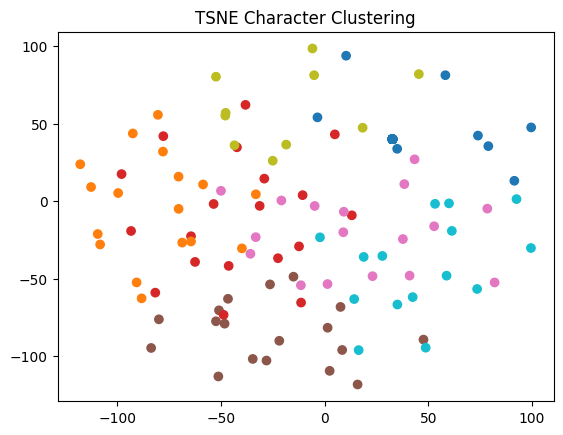

In [18]:
import matplotlib.pyplot as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='tab10')
plt.title("TSNE Character Clustering")
plt.show()


In [19]:
print(df_filtered.columns)


Index(['Unnamed: 0', 'character_name', 'bio', 'gender', 'is_female',
       'normalized_title', 'id', 'title', 'author', 'language', 'subjects',
       'bookshelves', 'copyright_status', 'media_type', 'formats',
       'download_link', 'textContent', 'translator', 'translation_date',
       'original_date', 'date_range_confidence', 'quotes_by', 'quotes_about',
       'unrelated_quotes', 'raw_quotes', 'Unnamed: 0.1', 'quotes',
       'all_quotes', 'Embedding', 'Cluster', 'Embedding_reduced',
       'cluster_distance', 'cluster_strength', 'size', 'region', 'lat', 'lon',
       'saidvsabout'],
      dtype='object')


In [20]:
df_filtered['Embedding']

0      [0.11858034, -0.008555418, 0.005579451, 0.0521...
1      [0.12486495, 0.007550858, 0.0010326663, 0.0380...
2      [0.103975356, 0.0067590987, -0.01073271, 0.052...
3      [0.09544028, 0.02028007, 0.010535913, 0.041368...
4      [0.10181236, -0.010661398, -0.0022331881, 0.04...
                             ...                        
140    [0.013767232, -0.04750013, -0.042052742, 0.103...
141    [0.013767232, -0.04750013, -0.042052742, 0.103...
142    [0.013767232, -0.04750013, -0.042052742, 0.103...
143    [0.047330614, -9.2825154e-05, -0.022270765, 0....
144    [0.07307801, 0.02575569, -0.04704322, 0.027746...
Name: Embedding, Length: 145, dtype: object

In [21]:
# Show characters grouped by cluster
for cluster in sorted(df_filtered['Cluster'].unique()):
    print(f"\n🌀 Cluster {cluster}")
    print(df_filtered[df_filtered['Cluster'] == cluster]['character_name'].tolist())



🌀 Cluster 0
['Oborozukiyo', 'Siduri', "Utanapishtim's Wife", 'Aruru', 'Antum', 'durga', 'kalaratri', 'gandhari', 'dushala', 'chitrāngadā', 'devayani', 'skylla', 'charybdis', 'chandrabhaga', 'kalypso', 'antikleia', 'melantho', 'jambavati', 'kadru', 'Anna', 'gerlinde', 'adrika', 'The Water-Fairies / The Nixies', 'sulochana', 'bhadrakali', 'Aughumla', 'hidimbi', 'kassandra', 'madri', 'padmavati', 'radha', 'malini', 'iphthime', 'klytaimestra', 'arete', 'nausikaa', 'valandhara', "vidura's wife (sulabha)", 'circe', 'shanta', 'shabari', 'shrutakirti', 'sunayana', 'tataka', 'shakuntala', 'sudeshna', 'tapati', 'tilottama', 'the sirens']

🌀 Cluster 1
['Ninsun', 'Ilmatar', 'hecuba', 'thetis', 'aphrodite', 'Juno', 'Allecto', 'Venus', 'Camilla', 'ulupi', 'yashoda', 'kunti', 'mandodari', 'manthara', 'shurpanakha', 'trijata', 'vedavati']

🌀 Cluster 2
['Lady Fujitsubo', 'Utsusemi', 'Yūgao', 'Lady Rokujō', 'Lady Murasaki', 'Gordafarid', 'Sudabeh', 'Tahmineh', 'Zosia', 'Malinche', 'Shamhat', 'gudrun', 

In [22]:
import numpy as np

# Assuming you have already created X_reduced
df_filtered['Embedding_reduced'] = list(X_reduced)

# Step 1: Compute cluster centers based on reduced embeddings
centers = df_filtered.groupby('Cluster')['Embedding_reduced'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)
).to_dict()

# Step 2: Define distance computation function
def distance_to_center_reduced(embedding_reduced, cluster_label):
    center = centers[cluster_label]
    return np.linalg.norm(embedding_reduced - center)

# Step 3: Apply distance computation
df_filtered['cluster_distance'] = df_filtered.apply(
    lambda row: distance_to_center_reduced(np.array(row['Embedding_reduced']), row['Cluster']), axis=1
)

# Step 4: Define cluster strength
df_filtered['cluster_strength'] = 1 / (1 + df_filtered['cluster_distance'])


In [23]:
print(df_filtered['Embedding'].iloc[0].shape)          # (384,)
print(df_filtered['Embedding_reduced'].iloc[0].shape)  # (50,) ← matches KMeans!


(768,)
(3,)


In [24]:
print(df_filtered.columns)
print(df_filtered['cluster_distance'])
print(df_filtered['cluster_strength'])

Index(['Unnamed: 0', 'character_name', 'bio', 'gender', 'is_female',
       'normalized_title', 'id', 'title', 'author', 'language', 'subjects',
       'bookshelves', 'copyright_status', 'media_type', 'formats',
       'download_link', 'textContent', 'translator', 'translation_date',
       'original_date', 'date_range_confidence', 'quotes_by', 'quotes_about',
       'unrelated_quotes', 'raw_quotes', 'Unnamed: 0.1', 'quotes',
       'all_quotes', 'Embedding', 'Cluster', 'Embedding_reduced',
       'cluster_distance', 'cluster_strength', 'size', 'region', 'lat', 'lon',
       'saidvsabout'],
      dtype='object')
0      35.361641
1      50.892696
2      63.254097
3      59.602444
4      53.437260
         ...    
140     5.670708
141     5.670708
142     5.670708
143    42.222500
144    55.313225
Name: cluster_distance, Length: 145, dtype: float32
0      0.027502
1      0.019271
2      0.015563
3      0.016501
4      0.018370
         ...   
140    0.149909
141    0.149909
142    0.1499

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Scale 'cluster_strength' to a size between (10, 100)
scaler = MinMaxScaler((10, 100))

# Create 'size' column from 'cluster_strength'
df_filtered['size'] = scaler.fit_transform(df_filtered[['cluster_strength']])


In [26]:
# Scale to radius between 4 and 30
df_filtered['size'] = np.interp(df_filtered['size'], 
                                (df_filtered['size'].min(), df_filtered['size'].max()), 
                                (4, 30))


In [27]:
#ignorant of style version: 

In [28]:
df_filtered['subjects']

0      Aristocracy (Social class) -- Japan -- Fiction...
1      Aristocracy (Social class) -- Japan -- Fiction...
2      Aristocracy (Social class) -- Japan -- Fiction...
3      Aristocracy (Social class) -- Japan -- Fiction...
4      Aristocracy (Social class) -- Japan -- Fiction...
                             ...                        
140                            Epic literature, Sanskrit
141                            Epic literature, Sanskrit
142    Epic poetry, Greek -- Translations into Englis...
143                            Epic literature, Sanskrit
144    Epic poetry, Sanskrit -- Translations into Eng...
Name: subjects, Length: 145, dtype: object

In [29]:
location_keywords = {
    'Greek':        {'region': 'Greece', 'lat': 37.9838, 'lon': 23.7275},
    'Homer':        {'region': 'Greece', 'lat': 37.9838, 'lon': 23.7275},
    'Odysseus':     {'region': 'Greece', 'lat': 37.9838, 'lon': 23.7275},
    'Rome':         {'region': 'Italy', 'lat': 41.9028, 'lon': 12.4964},
    'Latin':        {'region': 'Italy', 'lat': 41.9028, 'lon': 12.4964},
    'Sanskrit':     {'region': 'India', 'lat': 25.3176, 'lon': 82.9739},
    'Norse':        {'region': 'Scandinavia', 'lat': 60.4720, 'lon': 8.4689},
    'German':       {'region': 'Germany', 'lat': 51.1657, 'lon': 10.4515},
    'Scalds':       {'region': 'Scandinavia', 'lat': 60.4720, 'lon': 8.4689},
    'Finnish':      {'region': 'Finland', 'lat': 61.9241, 'lon': 25.7482},
    'Finland':      {'region': 'Finland', 'lat': 61.9241, 'lon': 25.7482},
    'Assyro-Babylonian': {'region': 'Mesopotamia', 'lat': 32.5421, 'lon': 44.4200},
    'Aztecs':       {'region': 'Mesoamerica', 'lat': 19.4326, 'lon': -99.1332},
    'Polish':       {'region': 'Poland', 'lat': 52.2297, 'lon': 21.0122},
    'Hiawatha': {
        'region': 'Northeastern North America',
        'lat': 43.0,
        'lon': -75.0
    },
    'Persian': {
        'region': 'Iran',
        'lat': 32.4279,
        'lon': 53.6880
    },
    'Pre-Islamic Iran': {
        'region': 'Iran',
        'lat': 32.4279,
        'lon': 53.6880
    },
    'Japan': {
    'region': 'Japan',
    'lat': 36.2048,
    'lon': 138.2529
}
}


In [30]:
def infer_location_from_subject(subject):
    subject = subject.lower()
    for keyword, info in location_keywords.items():
        if keyword.lower() in subject:
            return {'region': info['region'], 'lat': info['lat'], 'lon': info['lon']}
    return {'region': None, 'lat': None, 'lon': None}


In [31]:
location_info = df_filtered['subjects'].apply(infer_location_from_subject)

# Convert to DataFrame if needed
location_info_df = pd.DataFrame(location_info.tolist(), index=location_info.index)

# Replace each matching column individually
for col in location_info_df.columns:
    df_filtered[col] = location_info_df[col]


In [32]:
df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]


In [33]:
df_filtered.loc[
    df_filtered['normalized_title'].str.lower() == 'kalevala',
    ['region', 'lat', 'lon']
] = ['Finland', 61.9241, 25.7482]


In [34]:
df_filtered

,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,Embedding,Cluster,Embedding_reduced,cluster_distance,cluster_strength,size,region,lat,lon,saidvsabout
0,181,Lady Fujitsubo,(Her Highness/ Majesty Fujitsubo) – Daughter o...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.11858034, -0.008555418, 0.005579451, 0.0521...",2,"[-64.426544, -22.597471, 90.525154]",35.361641,0.027502,6.899100,Japan,36.2048,138.2529,0.571429
1,182,Ōmyōbu,(Fujitsubo's Ōmyōbu) – She is a lady-in-waitin...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.12486495, 0.007550858, 0.0010326663, 0.0380...",3,"[-48.233932, -78.95726, 43.045563]",50.892696,0.019271,5.345741,Japan,36.2048,138.2529,0.416667
2,185,Utsusemi,(空蝉/Cicada Shell/ Lady of the Locust Shell) – ...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.103975356, 0.0067590987, -0.01073271, 0.052...",2,"[-81.65412, -58.967346, 61.01867]",63.254097,0.015563,4.646091,Japan,36.2048,138.2529,0.354610
3,186,Chūjō,(Utsusemi's Chūjō) – She is Utsusemi's servant...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.09544028, 0.02028007, 0.010535913, 0.041368...",3,"[-83.64844, -94.61423, -9.643134]",59.602444,0.016501,4.823069,Japan,36.2048,138.2529,0.474860
4,188,Yūgao,– She is a woman of lower status of about nine...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.10181236, -0.010661398, -0.0022331881, 0.04...",2,"[-62.47974, -39.161858, 26.336863]",53.437260,0.018370,5.175748,Japan,36.2048,138.2529,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,364,tapati,Tapati is a river goddess. She is daughter ofS...,female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,"[0.013767232, -0.04750013, -0.042052742, 0.103...",0,"[32.651516, 39.961716, -1.1633974]",5.670708,0.149909,30.000000,India,25.3176,82.9739,1.000000
141,366,tilottama,"In the Hindu epicMahabharata, Tilottama is des...",female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,"[0.013767232, -0.04750013, -0.042052742, 0.103...",0,"[32.651516, 39.961716, -1.1633974]",5.670708,0.149909,30.000000,India,25.3176,82.9739,1.000000
142,152,the sirens,These are the dangerous ladies who lure men to...,female,1,odyssey,1727,The Odyssey: Rendered into English prose for t...,Homer,en,...,"[0.013767232, -0.04750013, -0.042052742, 0.103...",0,"[32.651516, 39.961716, -1.1633974]",5.670708,0.149909,30.000000,Greece,37.9838,23.7275,1.000000
143,349,sarama,"Sarama, according to theMahabharata, is a cele...",female,1,mahabharata,15474,"The Mahabharata of Krishna-Dwaipayana Vyasa, V...",Unknown,en,...,"[0.047330614, -9.2825154e-05, -0.022270765, 0....",4,"[37.71204, -24.445995, -106.54284]",42.222500,0.023136,6.075255,India,25.3176,82.9739,0.514970


In [35]:
df_filtered[df_filtered['region'].isnull() | (df_filtered['region'] == 'None') | (df_filtered['region'] == None)]


,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,Embedding,Cluster,Embedding_reduced,cluster_distance,cluster_strength,size,region,lat,lon,saidvsabout
67,39,Signy,Daughter of Volsung and sister to Sigmund. She...,female,1,volsunga saga,1152,The Story of the Volsungs (Volsunga Saga); wit...,Unknown,en,...,"[0.05087847, -0.016610209, 0.0038096104, 0.020...",6,"[73.49941, -56.590164, 33.238514]",32.066906,0.030242,7.416234,None,NaN,NaN,0.436009
68,40,Brynhild,A valkyrie and daughter of Budli. She is first...,female,1,volsunga saga,1152,The Story of the Volsungs (Volsunga Saga); wit...,Unknown,en,...,"[0.050150946, -0.0073591117, -0.020670086, 0.0...",6,"[27.809875, -35.315872, 32.971592]",22.511078,0.042533,9.735886,None,NaN,NaN,0.776130


In [36]:
# Define the correct region info
volsunga_fix = {
    'region': 'Scandinavia',
    'lat': 60.4720,
    'lon': 8.4689
}

# Mask for entries from Volsunga Saga with missing region
mask = (df_filtered['normalized_title'] == 'volsunga saga') & (df_filtered['region'].isna())

# Apply the fix
df_filtered.loc[mask, 'region'] = volsunga_fix['region']
df_filtered.loc[mask, 'lat'] = volsunga_fix['lat']
df_filtered.loc[mask, 'lon'] = volsunga_fix['lon']


In [37]:
df_filtered[['character_name', 'region']]

,character_name,region
0,Lady Fujitsubo,Japan
1,Ōmyōbu,Japan
2,Utsusemi,Japan
3,Chūjō,Japan
4,Yūgao,Japan
...,...,...
140,tapati,India
141,tilottama,India
142,the sirens,Greece
143,sarama,India


In [38]:
df_filtered.columns

Index(['Unnamed: 0', 'character_name', 'bio', 'gender', 'is_female',
       'normalized_title', 'id', 'title', 'author', 'language', 'subjects',
       'bookshelves', 'copyright_status', 'media_type', 'formats',
       'download_link', 'textContent', 'translator', 'translation_date',
       'original_date', 'date_range_confidence', 'quotes_by', 'quotes_about',
       'unrelated_quotes', 'raw_quotes', 'Unnamed: 0.1', 'quotes',
       'all_quotes', 'Embedding', 'Cluster', 'Embedding_reduced',
       'cluster_distance', 'cluster_strength', 'size', 'region', 'lat', 'lon',
       'saidvsabout'],
      dtype='object')

In [39]:
df_filtered.loc[ 10, 'quotes']

['[\'You have tired of my friendship, then?\', \'I shall bestow Mazanderan on you, from border to border, but there are still long, difficult days of struggle ahead, in which we will see both good and bad fortune. We have to drag the king of Mazanderan down from his throne and fling him into a pit, and our daggers have to sever the heads of thousands upon thousands of demons. When these things have been done I shall make you the lord of this earth and not betray my promise.\', \'Tell your king this, “Your arrogant attempt To cow me with your words provokes contempt. If you are Persia’s sovereign lord, if you Are like a lion in all you think and do, Iam seen, from beginning to end.\', \'Every man has his uses, and I asked Olad to be an honest guide for me, which he was. I encouraged him to hope for Mazanderan as a reward for his honesty.\', "There are not many Turks who can match themselves against me. I am Hejir, the army\'s brave commander, and I shall tear your head off and send it t

In [40]:
df_filtered['saidvsabout'] = df_filtered.apply(
    lambda row: len(row['quotes_by']) / len(row['quotes_about']) if len(row['quotes_about']) > 0 else float('inf'),
    axis=1
)


In [42]:
df_filtered.to_json('/Users/harshitachakravadhanula./Desktop/sem2/thesis/majorStudio2/thesis/src/assets/for_locations.json',
    orient='records')

In [43]:
df_filtered

,Unnamed: 0,character_name,bio,gender,is_female,normalized_title,id,title,author,language,...,Embedding,Cluster,Embedding_reduced,cluster_distance,cluster_strength,size,region,lat,lon,saidvsabout
0,181,Lady Fujitsubo,(Her Highness/ Majesty Fujitsubo) – Daughter o...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.11858034, -0.008555418, 0.005579451, 0.0521...",2,"[-64.426544, -22.597471, 90.525154]",35.361641,0.027502,6.899100,Japan,36.2048,138.2529,0.609562
1,182,Ōmyōbu,(Fujitsubo's Ōmyōbu) – She is a lady-in-waitin...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.12486495, 0.007550858, 0.0010326663, 0.0380...",3,"[-48.233932, -78.95726, 43.045563]",50.892696,0.019271,5.345741,Japan,36.2048,138.2529,0.562298
2,185,Utsusemi,(空蝉/Cicada Shell/ Lady of the Locust Shell) – ...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.103975356, 0.0067590987, -0.01073271, 0.052...",2,"[-81.65412, -58.967346, 61.01867]",63.254097,0.015563,4.646091,Japan,36.2048,138.2529,0.321055
3,186,Chūjō,(Utsusemi's Chūjō) – She is Utsusemi's servant...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.09544028, 0.02028007, 0.010535913, 0.041368...",3,"[-83.64844, -94.61423, -9.643134]",59.602444,0.016501,4.823069,Japan,36.2048,138.2529,0.430914
4,188,Yūgao,– She is a woman of lower status of about nine...,female,1,tale of genji,66057,The Tale of Genji,Murasaki Shikibu,en,...,"[0.10181236, -0.010661398, -0.0022331881, 0.04...",2,"[-62.47974, -39.161858, 26.336863]",53.437260,0.018370,5.175748,Japan,36.2048,138.2529,0.422886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,364,tapati,Tapati is a river goddess. She is daughter ofS...,female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,"[0.013767232, -0.04750013, -0.042052742, 0.103...",0,"[32.651516, 39.961716, -1.1633974]",5.670708,0.149909,30.000000,India,25.3176,82.9739,1.000000
141,366,tilottama,"In the Hindu epicMahabharata, Tilottama is des...",female,1,mahabharata,11894,The Mahabharata of Krishna-Dwaipayana Vyasa Tr...,Unknown,en,...,"[0.013767232, -0.04750013, -0.042052742, 0.103...",0,"[32.651516, 39.961716, -1.1633974]",5.670708,0.149909,30.000000,India,25.3176,82.9739,1.000000
142,152,the sirens,These are the dangerous ladies who lure men to...,female,1,odyssey,1727,The Odyssey: Rendered into English prose for t...,Homer,en,...,"[0.013767232, -0.04750013, -0.042052742, 0.103...",0,"[32.651516, 39.961716, -1.1633974]",5.670708,0.149909,30.000000,Greece,37.9838,23.7275,1.000000
143,349,sarama,"Sarama, according to theMahabharata, is a cele...",female,1,mahabharata,15474,"The Mahabharata of Krishna-Dwaipayana Vyasa, V...",Unknown,en,...,"[0.047330614, -9.2825154e-05, -0.022270765, 0....",4,"[37.71204, -24.445995, -106.54284]",42.222500,0.023136,6.075255,India,25.3176,82.9739,0.514970


In [48]:
df_filtered[
    [
        'character_name', 'bio', 'normalized_title', 'title', 'author',
        'subjects', 'bookshelves', 'translator', 'translation_date',
        'original_date', 'date_range_confidence', 'Cluster',
        'cluster_strength', 'size', 'region', 'lat', 'lon', 'saidvsabout', 'quotes'
    ]
].rename(
    columns={
        'character_name': 'character',
        'Cluster': 'archetype',
        'cluster_strength': 'strength'
    }
).to_json(
    '/Users/harshitachakravadhanula./Desktop/sem2/thesis/majorStudio2/thesis/public/data.json',
    orient='records'
)


In [438]:
df_filtered['original_date'].unique()

array([ 1008,  1000,  1855,  1834,  1860, -2100,  1835,  -400,  -750,
        -800,  -300,  1200,   -19,  1270,  1220])

In [439]:
df_filtered['date_range_confidence'].unique()

array([ 10,   0, 400,   5, 300, 100,  50])

In [440]:
df_filtered.to_csv("/Users/harshitachakravadhanula./Desktop/sem2/thesis/Dataset/archetype finals/archetypes_latest.csv", index=False)


In [49]:
df_filtered.to_json(
    '/Users/harshitachakravadhanula./Desktop/sem2/thesis/majorStudio2/thesis/src/assets/data.json',
    orient='records'
)

In [44]:
# Using str.title(), which capitalizes the first letter of each word
df_filtered['character_name'] = df_filtered['character_name'].str.title()


In [47]:
df_filtered.columns

Index(['Unnamed: 0', 'character_name', 'bio', 'gender', 'is_female',
       'normalized_title', 'id', 'title', 'author', 'language', 'subjects',
       'bookshelves', 'copyright_status', 'media_type', 'formats',
       'download_link', 'textContent', 'translator', 'translation_date',
       'original_date', 'date_range_confidence', 'quotes_by', 'quotes_about',
       'unrelated_quotes', 'raw_quotes', 'Unnamed: 0.1', 'quotes',
       'all_quotes', 'Embedding', 'Cluster', 'Embedding_reduced',
       'cluster_distance', 'cluster_strength', 'size', 'region', 'lat', 'lon',
       'saidvsabout'],
      dtype='object')

In [52]:
 df_filtered['archetype']

KeyError: 'archetype'